<a href="https://colab.research.google.com/github/Haebuk/dataminingTP/blob/main/TermProject_multituning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
!pip install https://s3-us-west-2.amazonaws.com/xgboost-nightly-builds/xgboost-1.4.0_SNAPSHOT%2B4224c08cacceba3f83f90e387c07aa6205a83bfa-py3-none-manylinux2010_x86_64.whl
from tqdm import tqdm
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso,  Ridge, LassoLarsIC
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.model_selection import KFold, cross_val_score, train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import xgboost as xgb
# After running
! git clone --recursive https://github.com/Microsoft/LightGBM
#You can run this oneliner which will build and compile LightGBM with GPU enabled in colab:
! cd LightGBM && rm -rf build && mkdir build && cd build && cmake -DUSE_GPU=1 ../../LightGBM && make -j4 && cd ../python-package && python3 setup.py install --precompile --gpu;
!mkdir -p /etc/OpenCL/vendors && \ echo "/usr/lib/x86_64-linux-gnu/libnvidia-opencl.so.1" > /etc/OpenCL/vendors/nvidia.icd
import lightgbm as lgb
import re
!pip install optuna -q
import optuna
from optuna.integration import XGBoostPruningCallback
from sklearn.externals import joblib
import pickle

import matplotlib as mpl  # 기본 설정 만지는 용도
import matplotlib.pyplot as plt  # 그래프 그리는 용도
import matplotlib.font_manager as fm
!apt-get update -qq
!apt-get install fonts-nanum* -qq
path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'  # 설치된 나눔글꼴중 원하는 녀석의 전체 경로를 가져오자
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)
fm._rebuild()
mpl.rcParams['axes.unicode_minus'] = False

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


  Using cached https://s3-us-west-2.amazonaws.com/xgboost-nightly-builds/xgboost-1.4.0_SNAPSHOT%2B4224c08cacceba3f83f90e387c07aa6205a83bfa-py3-none-manylinux2010_x86_64.whl
  Found existing installation: xgboost 1.4.0-SNAPSHOT
    Uninstalling xgboost-1.4.0-SNAPSHOT:
      Successfully uninstalled xgboost-1.4.0-SNAPSHOT
fatal: destination path 'LightGBM' already exists and is not an empty directory.
-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- 

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning:

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.



NanumGothic Eco


In [ ]:
PATH = '/content/drive/MyDrive/input/dataminingTP/'
train_df = pd.read_csv(PATH + 'train_df_regex.csv')
all_df = pd.read_csv(PATH + 'all_df.csv')

In [ ]:
all_df.head()

,dong,apt,year_of_completion,transaction_year_month,floor,top10,log_price,log_area,city_부산광역시,city_서울특별시
0,138,23,41,0,6,0,10.532123,4.452252,0,1
1,65,23,12,0,10,0,9.903538,4.606869,0,1
2,65,23,46,0,10,0,10.558439,4.451319,0,1
3,13,23,42,0,19,0,11.678448,4.993082,0,1
4,13,23,43,0,7,0,11.695255,5.275202,0,1


In [ ]:
train_df = all_df[:train_df.shape[0]]
train_y = train_df['log_price']
train_X = train_df.drop('log_price', axis=1)
test_df = all_df[train_df.shape[0]:].drop('log_price', axis=1)
print(train_df.shape, test_df.shape, train_X.shape, train_y.shape)

(1216553, 10) (5463, 9) (1216553, 9) (1216553,)


In [ ]:
def RMSE(y, y_pred):
    rmse = mean_squared_error(y, y_pred) ** 0.5
    return rmse

def rmse_cv(model):
    tscv = TimeSeriesSplit(n_splits=10)
    rmse_list = []
    for i, (train_index, test_index) in enumerate(tscv.split(train_X), start=1):
        X_train, X_test = train_X.iloc[train_index], train_X.iloc[test_index]
        y_train, y_test = train_y.iloc[train_index], train_y.iloc[test_index]
        clf = model.fit(X_train, y_train)
        pred = clf.predict(X_test)
        rmse = RMSE(y_test, pred) 
        rmse_list.append(rmse)
    return type(model).__name__, rmse_list

def print_rmse_score(model):
    model_name, score = rmse_cv(model)
    for i, r in tqdm(enumerate(score, start=1), leave=True):
        if i == 1:
            print('\n')
            print(f'{i} FOLDS: {model_name} RMSE: {r:.4f}')
        else:
            print(f'{i} FOLDS: {model_name} RMSE: {r:.4f}')
    print(f'\n{model_name} mean RMSE: {np.mean(score):.4f}')
    print('='*40)

In [ ]:
cut = int(len(train_df)*0.8)
h_train = train_df[:cut]
h_valid = train_df[cut:]

h_train_X = h_train.drop('log_price', axis=1)
h_train_y = h_train['log_price']
h_valid_X = h_valid.drop('log_price', axis=1)
h_valid_y = h_valid['log_price']
print(h_train_X.shape, h_train_y.shape, h_valid_X.shape, h_valid_y.shape)

(973242, 9) (973242,) (243311, 9) (243311,)


In [ ]:
from optuna.samplers import TPESampler

sampler = TPESampler(seed=10)
n_repeats=3

def objective(trial):
    dtrain = xgb.DMatrix(h_train_X, label=h_train_y)
    dtest = xgb.DMatrix(h_valid_X, label=h_valid_y)

    param = {
        'objective': 'reg:squarederror', # 회귀
         'eval_metric': 'rmse',
         "xgb_gpu_hist": 1,
         'verbosity': 0,
         'booster': 'gbtree', # gradient boosting decision tree
         'lambda': trial.suggest_loguniform('lambda', 1e-8, 1),
         'alpha': trial.suggest_loguniform('alpha', 1e-8, 1),
         'max_depth': trial.suggest_int('max_depth',3, 9),
         'learning_rate': 0.01,
         "eta": trial.suggest_loguniform("eta", 1e-8, 1.0),
         "gamma": trial.suggest_loguniform("gamma", 1e-8, 1.0),
         'n_estimators': trial.suggest_int('n_estimators', 700, 1500),
         'min_child_weight': trial.suggest_int('min_child_weight', 0, 10),
         'subsample': trial.suggest_loguniform('subsample', 0.4, 1)
    }

    model = xgb.XGBRegressor(**param)
    pruning_callback = XGBoostPruningCallback(trial, "validation_0-rmse")
    xgb_2 = model.fit(h_train_X, h_train_y, eval_set=[(h_valid_X, h_valid_y)], verbose=0,
                      eval_metric='rmse', callbacks=[pruning_callback])

    rmse = RMSE(h_valid_y, xgb_2.predict(h_valid_X))
    return rmse
        
study_xgb = optuna.create_study(direction='minimize', sampler=sampler)
study_xgb.optimize(objective, n_trials=50)

[I 2021-06-22 06:32:40,764] A new study created in memory with name: no-name-fc6e92d4-90f7-4736-8c4e-c4e325164ed3
/usr/local/lib/python3.7/dist-packages/xgboost/data.py:114: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

[I 2021-06-22 06:47:05,545] Trial 0 finished with value: 0.20048695605053843 and parameters: {'lambda': 0.014810344004555135, 'alpha': 1.4656004675652718e-08, 'max_depth': 7, 'eta': 0.00978207662259244, 'gamma': 9.728728830009641e-05, 'n_estimators': 880, 'min_child_weight': 2, 'subsample': 0.8029815922829752}. Best is trial 0 with value: 0.20048695605053843.
/usr/local/lib/python3.7/dist-packages/xgboost/data.py:114: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

[I 2021-06-22 07:05:38,802] Trial 1 finished with value: 0.19825546356718324 and parameters: {'lambda': 2.253651157496

In [ ]:
print('Best Trial: score {},\nparams {}'.format(study_xgb.best_trial.value, study_xgb.best_trial.params))

Best Trial: score 0.19466914964027004,
params {'lambda': 0.005943503728075847, 'alpha': 2.1627610787257848e-06, 'max_depth': 9, 'eta': 0.005207224083783965, 'gamma': 0.00021895503882644017, 'n_estimators': 813, 'min_child_weight': 4, 'subsample': 0.7418647364337652}


In [ ]:
optuna.visualization.plot_param_importances(study_xgb)

In [ ]:
trial = study_xgb.best_trial
xgb_params = trial.params
xgb_params

{'alpha': 2.1627610787257848e-06,
 'eta': 0.005207224083783965,
 'gamma': 0.00021895503882644017,
 'lambda': 0.005943503728075847,
 'max_depth': 9,
 'min_child_weight': 4,
 'n_estimators': 813,
 'subsample': 0.7418647364337652}

In [ ]:
final_xgb_model = xgb.XGBRegressor(**xgb_params)
final_xgb_model.fit(train_X, train_y, eval_metric='rmse')
final_xgb_pred = final_xgb_model.predict(test_df)

/usr/local/lib/python3.7/dist-packages/xgboost/data.py:114: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



In [ ]:
final_xgb_pred

array([10.220038 ,  9.39824  ,  9.503799 , ..., 10.8020525, 10.499101 ,
        9.708441 ], dtype=float32)

<BarContainer object of 9 artists>

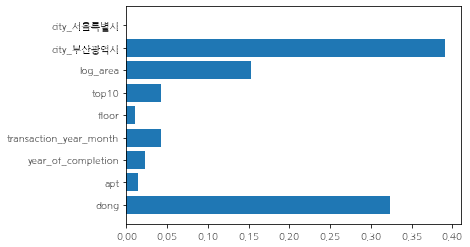

In [ ]:
plt.barh(train_X.columns, final_xgb_model.feature_importances_)

In [ ]:
final_pred_sub = np.expm1(final_xgb_pred)
final_pred_sub

array([27446.72 , 12066.125, 13409.583, ..., 49120.52 , 36281.86 ,
       16454.924], dtype=float32)

In [ ]:
sub = pd.read_csv(PATH + 'test.csv')
sub_df = pd.DataFrame({'transaction_id': sub['transaction_id'], 'transaction_real_price': final_pred_sub})
sub_df

,transaction_id,transaction_real_price
0,1145756,27446.720703
1,1198704,12066.125000
2,1222384,13409.583008
3,1179897,112344.523438
4,1223091,37538.347656
...,...,...
5458,1174640,50079.707031
5459,1175575,150977.171875
5460,1157024,49120.519531
5461,1136863,36281.859375


In [ ]:
sub_df.to_csv(PATH + 'submission_xgb_apt_extra_configuration.csv', index=False)